# Analyse de trajectoire entre deux parois

Code origine : $\mathrm{\color{red}{DoubleRigidWallOverdampedLangevin3D_cython}}$

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 05/10/2021

## 0. Déscription du problème :


Simulation et analyse d'une trajectoire brownienne proche de 2 parois rigide. 

Une particule de rayon $a$, de masse volumique $\rho$, plongé dans un fluide de viscosité $\eta_0$, soumise au poid $P=\Delta m g=(m_\mathrm{F}-m_\mathrm{P}) g$, où $m_\mathrm{F}$ est la masse de fluide déplacé par la poussé d'Archimède et $m_\mathrm{P}$, la masse de la particule.

Elle est placé entre deux parois rigides distante de $2H_p$. La particule est à une altitude $z$ de la paroi du bas (dont son centre est à $z+a$) et à une altitude $z' = 2H_p-2a-z$ de la paroi du haut.

La présence de la paroie induit une viscosité effective du fluide qui dépend de l'altitude $z$ de la particule $\eta(z)$ ; dans les dirrection collinaire $\eta_\|$ s'écrit:

\begin{equation}
    \eta_\| (z) = \frac{\eta_0}{\left( 1 - \frac{9a}{16(z+a)} +  \left( \frac{a}{8(z+a)} \right)^3 - \left( \frac{45a}{256(z+a)} \right)^4 - \left( \frac{a}{16(z+a)} \right)^5 \right)},
\end{equation}
obtenue dans l'approximation de Libshaber $z \ll a$.

Puis pour la direction transverse au mur $\eta_\perp$ on utilise l'approximation de lubrification $z \ll a$ tel que :
\begin{equation}
    \eta_{\mathrm{lubri}} (z) = \eta_0 ~ \frac{a}{z},
\end{equation}
Ce qui donne pour une double paroi :
\begin{equation}
    \eta_\perp (z) = \eta_{\mathrm{lubri}}^\mathrm{u}(z) + \eta_{\mathrm{lubri}}^\mathrm{d}(z) -\eta_0,
\end{equation}
\begin{equation}
    ~~~~~~ = \eta_0 ~ \left( \frac{a}{z} + \frac{a}{2H_p - 2a -z} - 1 \right),
\end{equation}

où $\eta_{\mathrm{lubri}}^\mathrm{u}$ la viscosité effective avec le mur du haut (up), $\eta_{\mathrm{lubri}}^\mathrm{d}$ celle avec le mur du bas (down) et $\eta_0$ la vicosité du fluide. $2 H_p$ est la distance entre les deux parois.

On concidère les effets inertiels négligeable et la particule est soumis au poids : on peux alors écrire l'équation de $\color{blue}{\mathrm{Langevin~sur~ amortie}}$ : 

\begin{equation}
    x(t+\tau) = x(t) + (P + F_\mathrm{corr} ) \frac{\tau}{\gamma (z)} + \sqrt{2D(z)} ~ dB_t ~ \tau
\end{equation}
où $D(z) = \frac{k_\mathrm{b}T}{6 \pi \eta_i(z) a}$, avec $i=\{ \|,\perp \}$.

Une force corrective $F_\mathrm{corr}$ est ajouté pour ajuster le cas sur-amortie.

\begin{equation}
    F_\mathrm{corr} = k_b T \frac{D_z'}{D_z} = k_b T \frac{42 R z^2 + 24 R^2z + 4R^2}{36 z^4 + 66Rz^3 + 30 R^2 z^2 + 4R^3 z}.
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import sys

sys.path.append(r"/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/PurePython")
from OverdampedLangevin3D import Langevin3D
from InertialLangevin3D import InertialLangevin3D
from RigidWallOverdampedLangevin3D import RigidWallOverdampedLangevin3D 
from RigidWall_InertialLangevin3D import RigidWallInertialLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit

import sys
import glob
from tqdm import tqdm
from scipy.optimize import curve_fit
from tqdm import trange
import matplotlib as mpl
mpl.rcParams['figure.dpi']=140
mpl.rcParams['xtick.direction']="in"
mpl.rcParams['ytick.direction']="in"
mpl.rcParams['lines.markeredgecolor']="k"
mpl.rcParams['lines.markeredgewidth']=0.2
mpl.rcParams['lines.markersize'] = 10
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
from sys import getsizeof

In [2]:
sys.path.append(r"/home/e.millan/Documents/Stage2020-Nageurs-actifs-proche-de-parois-deformable/Results")
from Functions_Analysis import plot_traj, MSD, P_z_wall, P_Deltaz_longTime

## 1. Calcul trajectoire avec code origine

In [3]:
dt = 1/60
Nt = 1000000
a = 1.5e-6
rho = 1050
r0 = (0., 0., 1.5e-6)


simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, R=a, rho=rho, x0=r0)
simu.trajectory()

Rs = np.zeros([Nt, 3])

Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

100%|██████████| 999999/999999 [00:25<00:00, 39414.22it/s]


## 2. Plot trajectoire

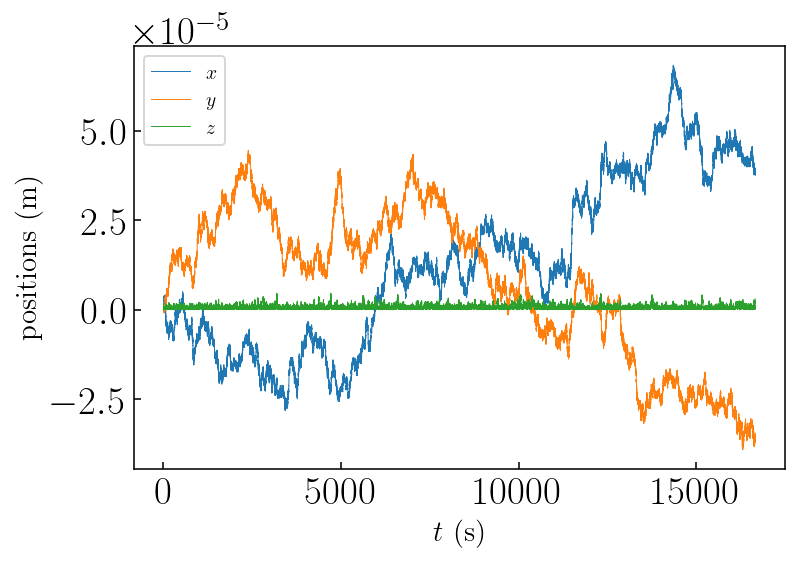

In [4]:
plot_traj(simu.t,Rs)

## 3. plot PDF

### 3.a) $P_\mathrm{eq}(z)$
La PDF théorique des altitudes $z$ à l'équilibre s'écrit :
\begin{equation}
    P_\mathrm{eq} (z) = N ~ \exp(- B ~ e^{- \frac{z}{l_\mathrm{d}} } - \frac{z}{l_\mathrm{b}} ),
\end{equation}
où $N$ est une constante de normalisation, $l_\mathrm{d}$ la longueur de Debye et $l_\mathrm{b}$ la longueur de Boltzman, $B=4.8$ un facteur déterminer expérimentalement $\color{red}{\mathrm{(À ~vérifier ~!!)}}$.

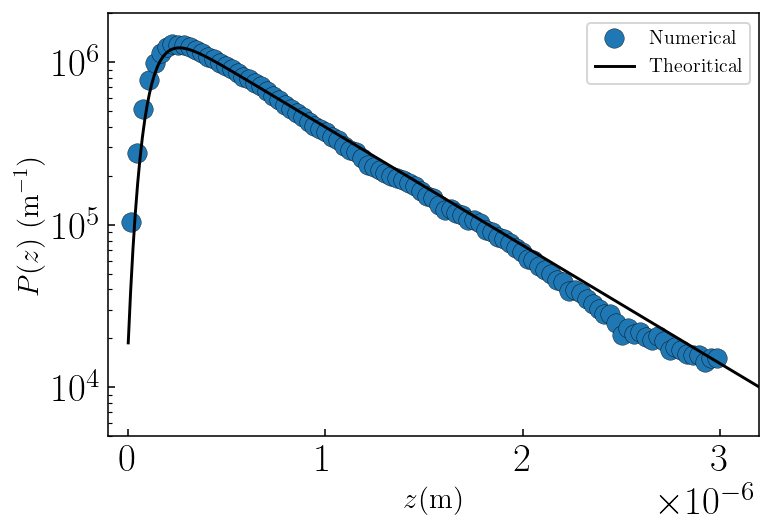

In [5]:
plt.axis([-1e-7, 3.2e-6, 5e3, 2e6])
simu.PDF("z", N_tau=10, space="wall", bins=100, plot=True)

On peut calculer la valeur moyenne des coeficients de diffusion collinaire et transverse à l'aide de $P_\mathrm{eq}(z)$ :
\begin{equation}
    \langle D_i \rangle_z = \int_{-\infty}^{+\infty} D_i ~ P_\mathrm{eq}(z) \mathrm{d}z .
\end{equation}

In [6]:
zth = np.linspace(1e-7, 3e-6, 200) ## Une liste de z
pdf_theo = P_z_wall(zth, 1, 4.8, simu.lD, simu.lB) ## P_eq(z)
Peq_z = pdf_theo/np.trapz(pdf_theo, zth) ## Normalisation par N

""" 
    Sur l'axe Z
"""
Dz = (simu.kb*simu.T) / (simu._gamma_z(zth)) ## D_\perp (z)
mean_Dz_theo = np.trapz(Dz * Peq_z, zth) ## <D_\perp (z)>
print("<Dz>_theo/D_0 = {:.2f}".format(mean_Dz_theo/(simu.kb * simu.T / simu.gamma)))

""" 
    Sur l'axe X
"""
Dx = (simu.kb*simu.T) / (simu._gamma_xy(zth)) ## D_|| (z)
mean_Dx_theo = np.trapz(Dx * Peq_z, zth)  ## <D_|| (z)>
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(simu.kb * simu.T / simu.gamma)))

<Dz>_theo/D_0 = 0.28
<Dx>_theo/D_0 = 0.6028324441


### 3.b) $P(\Delta x_i, \tau)$, $x_i = \{ x,y,z \}$.

La PDF des déplacement en $x$, $y$ et $z$ sont données par la relation: 


\begin{equation}
    P(\Delta x_i, \tau) = \frac{1}{N} \int_{-\infty}^{+\infty} P(D_i) \exp \left( -\frac{\Delta x_i^2}{4 D_i \tau} \right) ~\mathrm{d}D_i,
\end{equation}
où le déplacement est calculé à partir du retard $\tau$ tel que $\Delta x_i = x_i(t+\tau)-x_i(t)$ et $N$ est le facteur de normalisation.

La PDF des coeficients de disctributioin est donnée par :

\begin{equation}
    P(D_i) = \int_{-\infty}^{+\infty} D_i(z)~ P_\mathrm{eq}(z)~ \mathrm{d}z.
\end{equation}

Lorsque $\tau \rightarrow +\infty$, c'est-à-dire lorsque $\tau \gg \tau_\mathrm{c}$, la PDF des déplacements en $z$ devient :

\begin{equation}
    \lim_{\tau \rightarrow +\infty} P(\Delta z, \tau) = \int_{-\infty}^{+\infty} P_\mathrm{eq}(z+ \Delta z)~ P_\mathrm{eq}(z) ~\mathrm{d}z,
\end{equation}

où $\tau_\mathrm{c}$ est le temps caractéristique pour atteindre l'equilibre thermodynamique et est donnée par :

\begin{equation}
    \tau_\mathrm{c} = \frac{l_\mathrm{B} a}{D_0}.
\end{equation}

$\mathrm{\color{purple}{SOURCE~ :~ thèse~ Maxime, ~page ~90}}$.

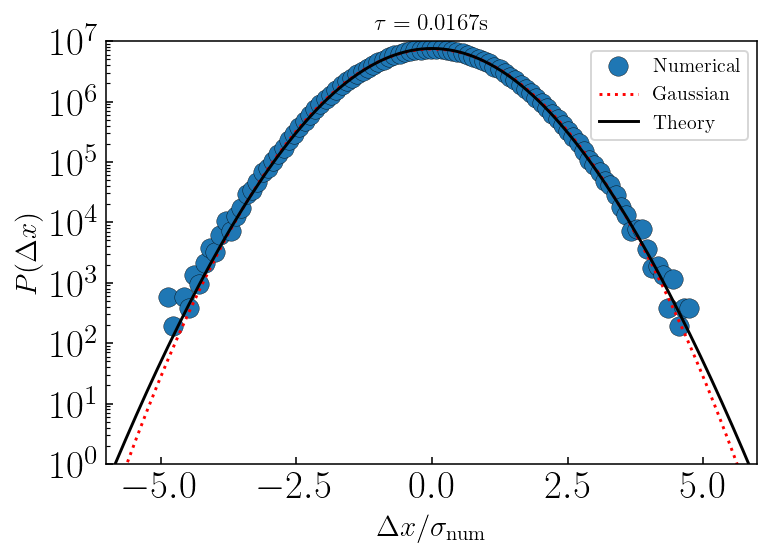

In [7]:
bins = 100
n_tau = 1
plt.axis([-6, 6,1e0, 1e7])
simu.PDF("dx", N_tau=n_tau, space="wall", bins=bins, plot=True)

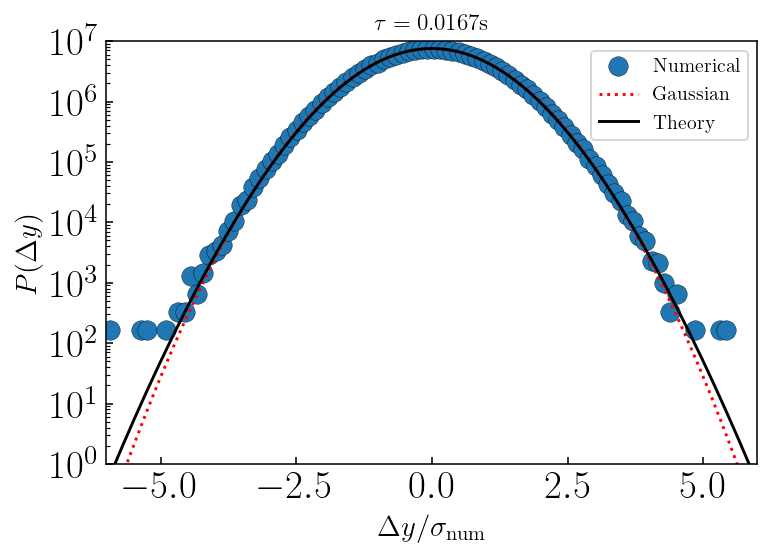

In [8]:
plt.axis([-6, 6,1e0, 1e7])
simu.PDF("dy", N_tau=n_tau, space="wall", bins=100, plot=True)

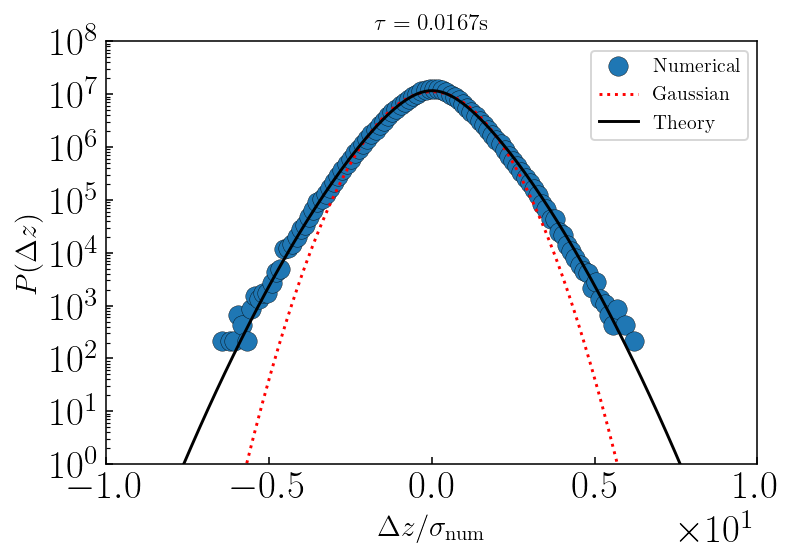

In [9]:
plt.axis([-10, 10,1e0, 1e8])
simu.PDF("dz", N_tau=n_tau, space="wall", bins=100, plot=True)

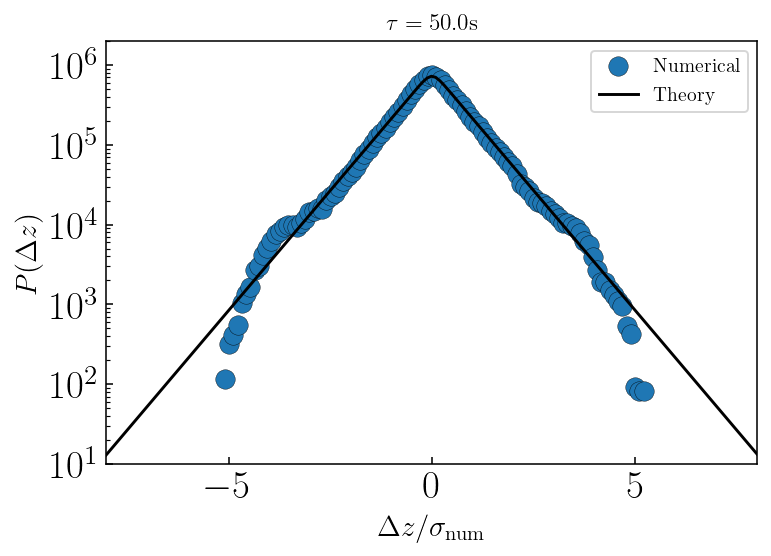

In [10]:
plt.axis([-8, 8,1e1, 2e6])
simu.PDF("dz", N_tau=3000, space="wall", bins=100, plot=True)

## 4. PLot MSD

100%|██████████| 54/54 [00:00<00:00, 373.22it/s]


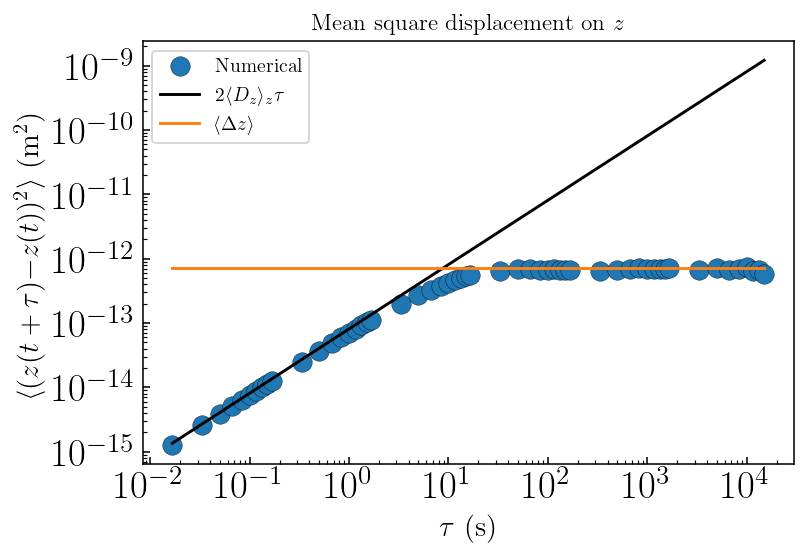

In [11]:
MSD("z", Rs, simu.dt, simu.Nt, D_mean=mean_Dz_theo, lD=simu.lD, lB=simu.lB, space="wall")

## 5. Cumulant ordre 4

Le calcul du cumulant d'ordre $4$ s'effectue à l'aide de la relation :

\begin{equation}
    C^{(4)} = \frac{1}{4!}\left( \langle z(t)-z(t+\tau) \rangle^4 - 3 \langle (z(t)-z(t+\tau)^2 \rangle^2 \right).
\end{equation}

Théoriquement, au temps court on a :
\begin{equation}
    \lim_{\tau \rightarrow 0}~C^{(4)} = \frac{\tau ^2}{2}\left( \langle D_{\|}^2 \rangle - \langle D_{\|} \rangle^2 \right),
\end{equation}
 et au temps long :
 
\begin{equation}
    \lim_{\tau \rightarrow +\infty}~C^{(4)} = C^{(4)}_0 \tau + C^{(4)}_1.
\end{equation}

 où $C^{(4)}_0$ et $C^{(4)}_1$ sont à determiner numériquement à l'aide du code d'Arthur Alexandre (cf. cumul4.py et note).

100%|██████████| 36/36 [00:00<00:00, 51.27it/s]


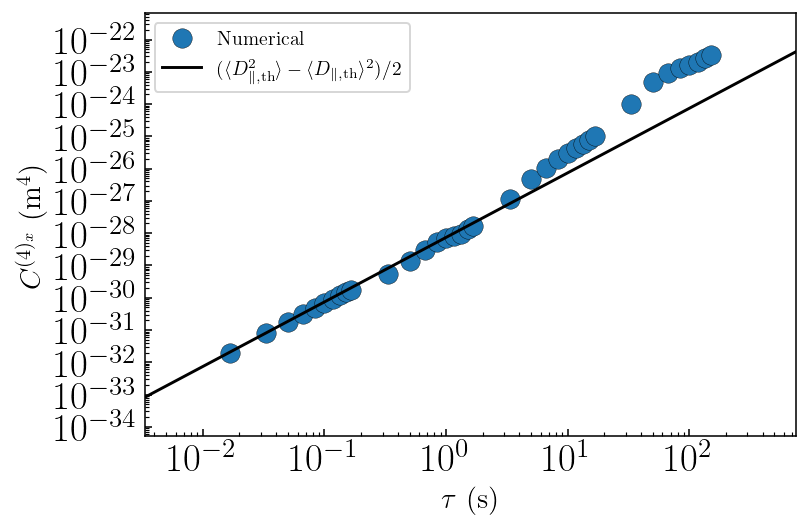

In [13]:
simu.Cumulant4(axis="x", plot=True, output=False)

### vérifier quand theorie en t² et en t se croise = $\tau_4$-> voir le code d'Arthur

### faire avec cython pour aller plus loin et vérifier la linéarité au temps long $\tau >> \tau_4$
